In [1]:
#encoding: utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# 导入数据此处仅导入9月份的数据
# .read_csv参数：sep指定间隔符号，header指定某一行为列标题，parse_dates解析某一列作为日期，encoding指定字符集类型
df1 = pd.read_csv(r"D:\大大大大大学\毕设\Data\用户行为_201809_01.csv",sep=',',header=0,parse_dates=["使用时间"],encoding='gb2312')
df2 = pd.read_csv(r"D:\大大大大大学\毕设\Data\用户行为_201809_02.csv",sep=',',header=0,parse_dates=["使用时间"],encoding='gb2312')
df3 = pd.read_csv(r"D:\大大大大大学\毕设\Data\用户行为_201809_03.csv",sep=',',header=0,parse_dates=["使用时间"],encoding='gb2312')
df4 = pd.read_csv(r"D:\大大大大大学\毕设\Data\用户行为_201809_04.csv",sep=',',header=0,parse_dates=["使用时间"],encoding='gb2312')
df5 = pd.read_csv(r"D:\大大大大大学\毕设\Data\用户行为_201809_05.csv",sep=',',header=0,parse_dates=["使用时间"],encoding='gb2312')
df6 = pd.read_csv(r"D:\大大大大大学\毕设\Data\用户行为_201809_06.csv",sep=',',header=0,parse_dates=["使用时间"],encoding='gb2312')
df7 = pd.read_csv(r"D:\大大大大大学\毕设\Data\用户行为_201809_07.csv",sep=',',header=0,parse_dates=["使用时间"],encoding='gb2312')
frames = [df1, df2, df3, df4, df5, df6, df7]
data = pd.concat(frames)
# concat是对几个数据集的拼接

In [3]:
def preprocess(cdr,GPS=False):
    if not GPS:
        cdr = cdr.drop('GPS经度',1).drop('GPS纬度',1).drop('省',1).drop('市',1)
        cdr['使用时间'] = pd.to_datetime(cdr['使用时间'])
        cdr = cdr[['IMEI',"日期",'使用时间','使用流量',"APP名称","使用时长"]]
        cdr = cdr.rename(columns={"日期":'date',"使用时间": "ds", "使用流量": "y","APP名称":"APP","使用时长":"time"})
        return cdr

def feature_extraction(traffic,t_index):
    traffic_resampled = traffic.groupby(['IMEI']).apply(lambda x: x.resample('1h', on='ds').sum().reindex(t_index).fillna(0))
    traffic_resampled.reset_index(inplace=True)
    traffic_resampled = traffic_resampled.rename(columns={"level_1": "ds"})
    traffic_resampled = traffic_resampled.set_index(['IMEI', 'ds'])
    traffic_resampled = traffic_resampled.unstack(level=-1)      
    return traffic_resampled

In [4]:
# cdr = preprocess(octe)
cdr = preprocess(data)
cdr = cdr.fillna(0)
# 空数据赋0
cdr.y = np.log10(cdr.y+1)
# 对流量数据取对数运算

## 特征提取

In [5]:
traffic = cdr[['IMEI','ds','y']]
# 取'IMEI','ds','y'三列数据
t_index = pd.date_range(start='2018-09-01', end='2018-09-30 23:00:00', freq='1h')
# date_range用于生成一个固定频率的时间索引
#t_index = pd.date_range(start='2018-10-01', end='2018-10-31 23:00:00', freq='1h')
traffic_resampled = traffic.groupby(['IMEI']).apply(lambda x: x.resample('1h', on='ds').sum().reindex(t_index).fillna(0))
# groupby表示对参数标签进行分组
# apply函数会自动遍历每一行DataFrame的数据，最后将所有结果组合成一个Series数据结构并返回
# lambda后面定义自变量为x的函数
# x.resample('1h', on='ds')表示对x的‘ds’以1h为频率重采样
# reindex(t_index)表示对表格以t_index的顺序行重排
traffic_resampled.reset_index(inplace=True)
# reset_index为去除索引，即把数据变为原来的表格形式
traffic_resampled = traffic_resampled.rename(columns={"level_1": "ds"})
# 运行时间：5min以内

In [6]:
traffic_resampled_coor = traffic_resampled.set_index(['IMEI', 'ds'])
# 设置两个索引值，将原始表格数据形成多层索引
traffic_resampled_coor = traffic_resampled_coor.unstack(level=-1)   
# unstack()即stack()的反操作，将行旋转到列，即把竖向排列的数据横过来，参数是层级序号

In [7]:
exe = traffic_resampled_coor.iloc[:,0:24]
# iloc[a,b]表示取第a行第b列的数据

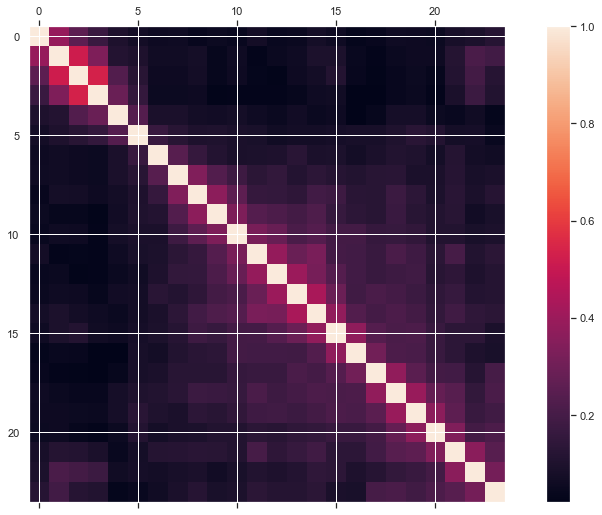

In [8]:
sns.set(rc={'figure.figsize':(15,8.75)})
#sns.heatmap(X.corr(), annot=True);
fig = plt.figure()
ax = fig.add_subplot(111)
# 创建子图，参数三个数表示共有1*1个子图，这是第1个
cax = ax.matshow(exe.corr(), interpolation='nearest')
# matshow()表示绘制矩阵，根据颜色表示矩阵中数值大小
# corr表示计算相关系数矩阵
fig.colorbar(cax)
plt.show();

In [9]:
traffic_resampled['date'] = pd.to_datetime(traffic_resampled.ds.dt.date)
traffic_resampled['hour'] = traffic_resampled.ds.dt.hour
traffic_resampled['weekday'] = traffic_resampled['date'].dt.dayofweek
# 提取日期、时间、星期几信息

In [10]:
traffic_resampled_week = traffic_resampled.groupby(['IMEI','weekday','hour']).mean().unstack(level=-2).unstack(level=-1)
# 设置三个索引值'IMEI','weekday','hour'，计算每个用户一星期内每小时使用的平均流量

## KMO测试

In [11]:
def partial_correlations(data):
    """
    This is a python port of the `pcor` function implemented in
    the `ppcor` R package, which computes partial correlations
    of each pair of variables in the given data frame `data`,
    excluding all other variables.

    Parameters
    ----------
    data : pd.DataFrame
        Data frame containing the feature values.

    Returns
    -------
    df_pcor : pd.DataFrame
        Data frame containing the partial correlations of of each
        pair of variables in the given data frame `df`,
        excluding all other variables.
    """
# 本函数能够计算输入值的偏相关函数并返回
    numrows, numcols = data.shape
    df_cov = data.cov()
# 计算data的协方差
    columns = df_cov.columns
# 提取出协方差矩阵中的列名存在columns中
    empty_array = np.empty((len(columns), len(columns)))
    empty_array[:] = np.nan
    if numcols > numrows:
        icvx = empty_array
# 若列数大于行数，则icvx为空矩阵
    else:
        try:
            icvx = np.linalg.inv(df_cov)
        except np.linalg.LinAlgError:
            icvx = empty_array
# 此时icvx中存储的就是df_cov的逆矩阵
    pcor = -1 * covariance_to_correlation(icvx)
    np.fill_diagonal(pcor, 1.0)
# 将对角线元素全部填充为1
    df_pcor = pd.DataFrame(pcor, columns=columns, index=columns)
    return df_pcor

def covariance_to_correlation(m):
    """
    This is a port of the R `cov2cor` function.

    Parameters
    ----------
    m : numpy array
        The covariance matrix.

    Returns
    -------
    retval : numpy array
        The cross-correlation matrix.

    Raises
    ------
    ValueError
        If the input matrix is not square.
    """

    # make sure the matrix is square
    numrows, numcols = m.shape
    if not numrows == numcols:
        raise ValueError('Input matrix must be square')

    Is = np.sqrt(1 / np.diag(m))
    retval = Is * m * np.repeat(Is, numrows).reshape(numrows, numrows)
    np.fill_diagonal(retval, 1.0)
    return retval

def calculate_kmo(data):
    """
    Calculate the Kaiser-Meyer-Olkin criterion
    for items and overall. This statistic represents
    the degree to which each observed variable is
    predicted, without error, by the other variables
    in the dataset. In general, a KMO < 0.6 is considered
    inadequate.

    Parameters
    ----------
    data : pd.DataFrame
        The data frame from which to calculate KMOs.

    Returns
    -------
    kmo_per_variable : pd.DataFrame
        The KMO score per item.
    kmo_total : float
        The KMO score overall.
    """

    # calculate the partial correlations
    partial_corr = partial_correlations(data)
    partial_corr = partial_corr.values

    # calcualte the pair-wise correlations
    corr = data.corr()
    corr = corr.values

    # fill matrix diagonals with zeros
    # and square all elements
    np.fill_diagonal(corr, 0)
    np.fill_diagonal(partial_corr, 0)

    partial_corr = partial_corr**2
    corr = corr**2

    # calculate KMO per item
    partial_corr_sum = partial_corr.sum(0)
    corr_sum = corr.sum(0)
# sum(0)表示按列相加
    kmo_per_item = corr_sum / (corr_sum + partial_corr_sum)
    kmo_per_item = pd.DataFrame(kmo_per_item,
                                index=data.columns,
                                columns=['KMO'])

    # calculate KMO overall
    corr_sum_total = corr.sum()
    partial_corr_sum_total = partial_corr.sum()
    kmo_total = corr_sum_total / (corr_sum_total + partial_corr_sum_total)
    return kmo_per_item, kmo_total

In [20]:
#X1 = X[1:]
#df_features = pd.DataFrame(X1)
X = traffic_resampled_week
kmo_per_item, kmo = calculate_kmo(X)
# KMO分析结果返回值有两项，第一项为168个特征值各自的KMO系数，第二项是平均KMO
kmo

0.9762588777132575

In [13]:
kmo_per_item.unstack(level=-1)

KMO                                                    \
hour             0         1         2         3         4         5    
  weekday                                                               
y 0        0.968506  0.955734  0.943848  0.947065  0.959884  0.970788   
  1        0.956862  0.939540  0.930716  0.949360  0.945764  0.959902   
  2        0.942741  0.899664  0.881305  0.902959  0.922922  0.965132   
  3        0.931495  0.958597  0.945199  0.928534  0.956597  0.969655   
  4        0.925308  0.880798  0.905456  0.883923  0.888040  0.957895   
  5        0.957868  0.948064  0.935321  0.940154  0.960571  0.969555   
  6        0.951707  0.935012  0.935284  0.939582  0.959623  0.964092   

                                                   ...                      \
hour             6         7         8         9   ...        14        15   
  weekday                                          ...                       
y 0        0.977410  0.983408  0.982432  0.982745  ...  0.983538  0.984099   
  1        0.981076  0.985420  0.984692  0.983563  ...  0.981004  0.983586   
  2        0.974113  0.979693  0.984622  0.984358  ...  0.980529  0.985037   
  3        0.982773  0.984595  0.984417  0.983913  ...  0.984524  0.984309   
  4        0.977536  0.983740  0.985853  0.982757  ...  0.983087  0.984659   
  5        0.981467  0.982671  0.981385  0.983662  ...  0.984312  0.983756   
  6        0.979222  0.983304  0.982881  0.980592  ...  0.981497  0.984615   

                                                                       \
hour             16        17        18        19        20        21   
  weekday                                                               
y 0        0.982629  0.976211  0.978342  0.980167  0.981150  0.974042   
  1        0.983903  0.986627  0.979547  0.978557  0.979488  0.981484   
  2        0.987291  0.985560  0.985562  0.977982  0.980891  0.977127   
  3        0.983368  0.984286  0.983405  0.977399  0.979973  0.975242   
  4        0.985600  0.983168  0.979753  0.982494  0.982851  0.975874   
  5        0.986279  0.984285  0.986625  0.983235  0.977875  0.978808   
  6        0.984696  0.986688  0.987277  0.983106  0.980465  0.978983   

                               
hour             22        23  
  weekday                      
y 0        0.959410  0.951315  
  1        0.973907  0.963776  
  2        0.976993  0.943468  
  3        0.960443  0.954284  
  4        0.968411  0.943153  
  5        0.976546  0.966849  
  6        0.974827  0.968938  

[7 rows x 24 columns]

## 探索性因子分析法EFA

In [24]:
from factor_analyzer import FactorAnalyzer
# factor_analyzer为因子分析法的库
# 我们事先不知道因子应该选取几个，现在先取168个然后作特征值图观察
fa = FactorAnalyzer(168, rotation=None)
fa.fit(X)
ev, v = fa.get_eigenvalues()
# 计算特征值

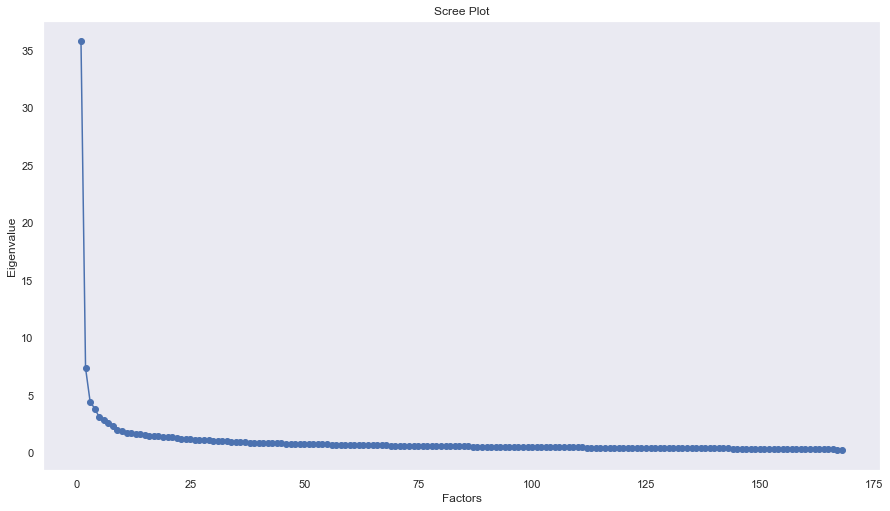

In [25]:
plt.scatter(range(1,X.shape[1]+1),ev)
plt.plot(range(1,X.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [26]:
# 观察特征值发现因子选择5比较合适
X = traffic_resampled_week
fa = FactorAnalyzer(5, rotation="varimax",method='ml')
# rotation表示选择回转方式，参数为方差则表示选择正交旋转方式
# method表示使用的拟合方法为最大似然法
fa.fit(X)
loadings2 = fa.loadings_
# loadings2是一个168*5的数组，为因子分析的结果

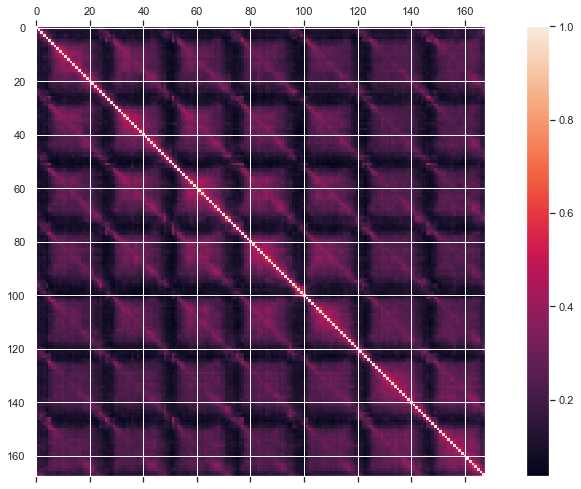

In [27]:
# 作周平均数据的自相关矩阵图
sns.set(rc={'figure.figsize':(15,8.27)})
fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(X.corr(), interpolation='nearest')
fig.colorbar(cax)
plt.show();

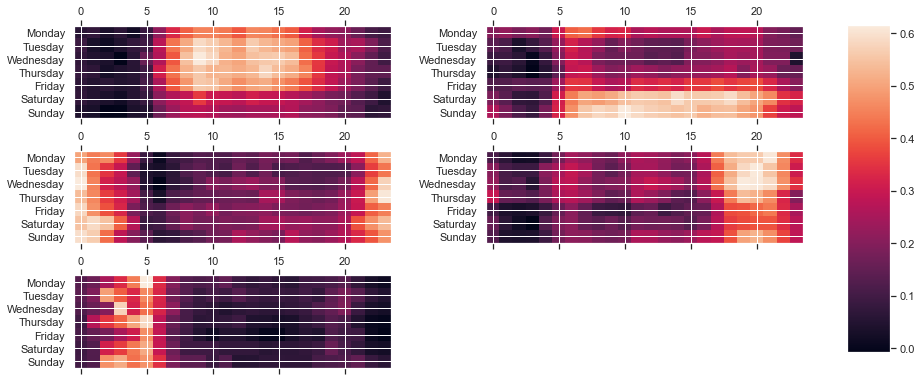

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import calendar


# factors = ['Factor1','Factor2','Factor3','Factor4','Factor5']
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,6.5))
i = 0
# ar=np.array(group)
for ax in axes.flat:
    if i==5:
        fig.delaxes(axes[2, 1])
        break
    im = ax.matshow(loadings2[:,i].reshape((7,24)))
# 注意图中最大值为0.62左右
    ax.set_yticks(np.arange(7))
# arange用于创建等差数组
    ax.set_yticklabels(calendar.day_name[0:7])
# 将纵坐标以星期命名
    i+=1

fig.subplots_adjust(right=0.8,wspace=0.3,hspace=0.2)
# 这个函数很好用，用于控制子图的边距和相邻的边距

cbar_ax = fig.add_axes([0.84, 0.17, 0.04, 0.7])
# 添加子图，参数为位置、大小信息
fig.colorbar(im, cax=cbar_ax)

plt.show()

<ipython-input-189-7880de6899e3>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(calendar.day_name[0:7],rotation=0)


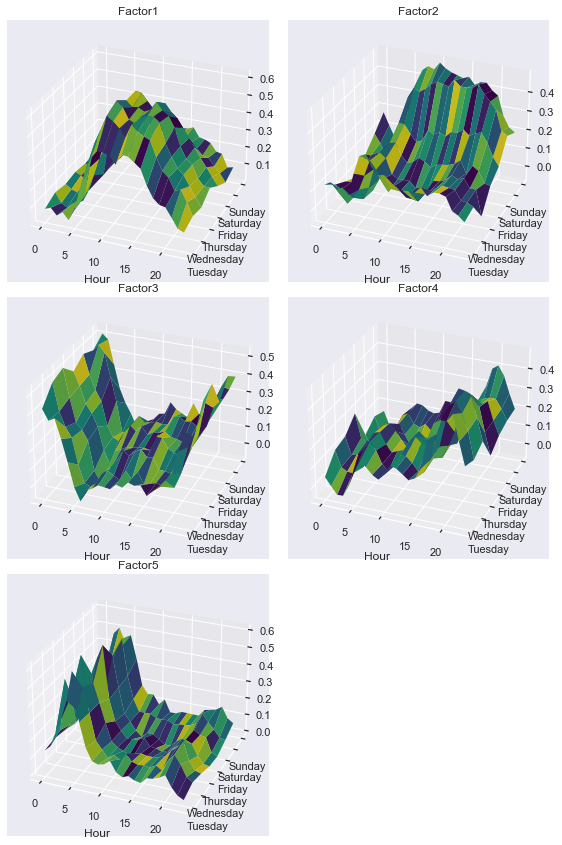

In [189]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np


factors = ['Factor1','Factor2','Factor3','Factor4','Factor5']
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,15),subplot_kw=dict(projection='3d'))
i = 0
# ar=np.array(group)
for ax in axes.flat:
    if i==5:
        fig.delaxes(axes[2, 1])
        break
    tt = loadings2[:,i].reshape((7,24))
    y = np.arange(tt.shape[0])
    x = np.arange(tt.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = tt
    
    data_value = np.random.rand(len(y), len(x))
# map the data to rgba values from a colormap
    colors = cm.ScalarMappable(cmap = "viridis").to_rgba(data_value)
    im = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=colors,
                       linewidth=0, antialiased=True)
    ax.set_yticklabels(calendar.day_name[0:7],rotation=0)
    ax.set_title(factors[i])
    ax.set_xlabel('Hour')
    
    ax.elev = 28
    ax.azim = -68
    
    i+=1
fig.subplots_adjust(wspace=0.01,hspace=0.06)
# 这个函数很好用，用于控制子图的边距和相邻的边距
plt.show()

<ipython-input-187-1403ab31b869>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(calendar.day_name[0:7])


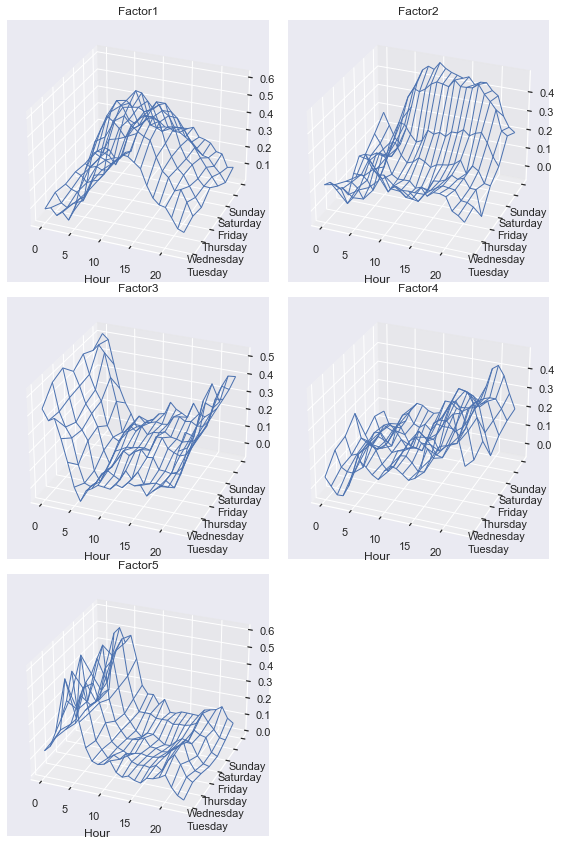

In [187]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np


factors = ['Factor1','Factor2','Factor3','Factor4','Factor5']
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,15),subplot_kw=dict(projection='3d'))
i = 0
# ar=np.array(group)
for ax in axes.flat:
    if i==5:
        fig.delaxes(axes[2, 1])
        break
    tt = loadings2[:,i].reshape((7,24))
    y = np.arange(tt.shape[0])
    x = np.arange(tt.shape[1])
    X, Y = np.meshgrid(x, y)
    Z = tt
    im = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1,linewidth=1)
    ax.set_yticklabels(calendar.day_name[0:7],rotation=0)
    ax.set_title(factors[i])
    ax.set_xlabel('Hour')
    
    ax.elev = 28
    ax.azim = -68
    
    i+=1
fig.subplots_adjust(wspace=0.01,hspace=0.06)
# 这个函数很好用，用于控制子图的边距和相邻的边距
plt.show()

### 数据检查模块

In [42]:
loadings2

array([[ 8.13808761e-02,  1.25027660e-01,  4.24273904e-01,
         4.62016100e-02,  1.32286618e-01],
       [ 9.51783775e-02,  1.43930174e-01,  3.66302033e-01,
         4.22485079e-03,  1.65102508e-01],
       [ 5.74093517e-02,  1.11919894e-01,  3.85414846e-01,
        -3.47212293e-02,  2.53098774e-01],
       [ 8.38090621e-02,  1.29404859e-01,  2.81337884e-01,
        -3.28676884e-02,  3.34833167e-01],
       [ 4.49480694e-02,  9.76277349e-02,  1.57550604e-01,
         2.41356418e-02,  4.46437999e-01],
       [ 1.08065811e-01,  2.14718441e-01,  2.47656195e-02,
         1.01369603e-01,  6.15650824e-01],
       [ 2.35772067e-01,  3.09800304e-01, -4.86280578e-02,
         1.64870193e-01,  3.37562294e-01],
       [ 3.47536200e-01,  3.25534503e-01,  1.82745074e-02,
         1.41183129e-01,  1.99263951e-01],
       [ 4.22169098e-01,  2.64349628e-01,  3.76555489e-02,
         1.08700646e-01,  1.28939089e-01],
       [ 4.65376994e-01,  2.30819484e-01,  6.30787683e-02,
         9.03655077e-02